In [56]:
import librosa
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive')
from IPython.display import Audio

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
filename = '/content/drive/MyDrive/piano_sample.mp3'
singlenote = '/content/drive/MyDrive/middlec.mp3'

input = filename

y, sr = librosa.load(input, sr=None)
harmonic, percussive = librosa.effects.hpss(y)

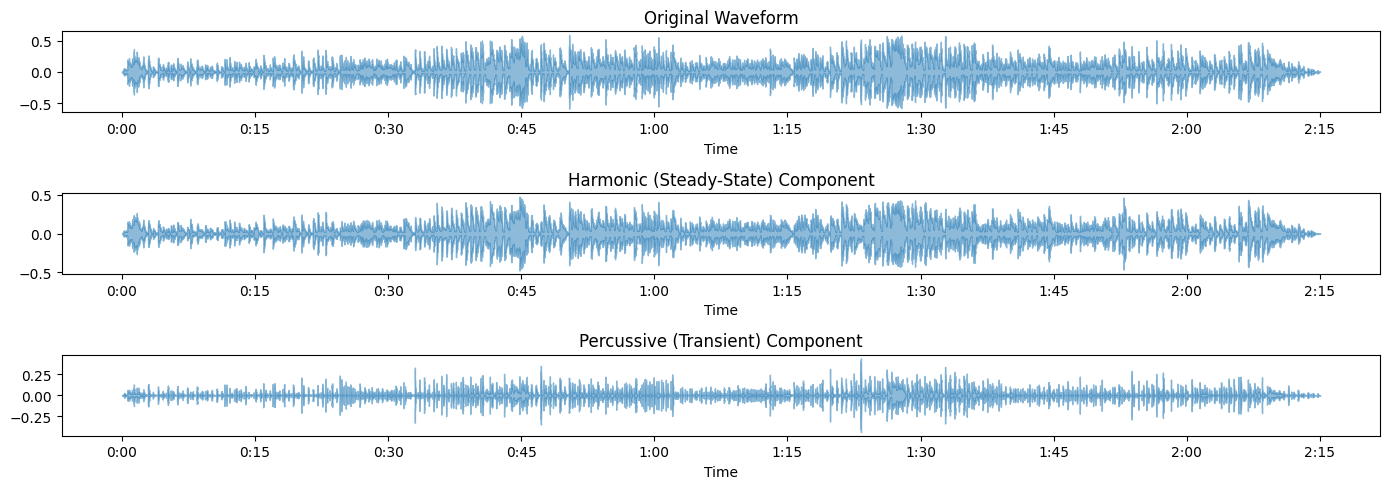

In [ ]:
plt.figure(figsize=(14, 5))

plt.subplot(3, 1, 1)
librosa.display.waveshow(y, sr=sr, alpha=0.5)
plt.title('Original Waveform')

plt.subplot(3, 1, 2)
librosa.display.waveshow(harmonic, sr=sr, alpha=0.5)
plt.title('Harmonic (Steady-State) Component')

plt.subplot(3, 1, 3)
librosa.display.waveshow(percussive, sr=sr, alpha=0.5)
plt.title('Percussive (Transient) Component')

plt.tight_layout()
plt.show()

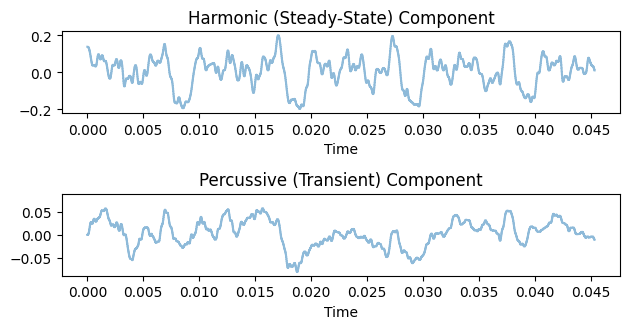

In [ ]:
plt.subplot(3, 1, 3)
librosa.display.waveshow(percussive[60000:62000], sr=sr, alpha=0.5)
plt.title('Percussive (Transient) Component')

plt.subplot(3, 1, 2)
librosa.display.waveshow(harmonic[60000:62000], sr=sr, alpha=0.5)
plt.title('Harmonic (Steady-State) Component')

plt.tight_layout()
plt.show()

In [ ]:
Audio(data=harmonic, rate=sr)

In [ ]:
Audio(data=percussive, rate=sr)

- Implement median filter to separate transient and ss
- Reading to understand the LMLs and GPs in general
- Spectrogram representation


**WEEK 2**

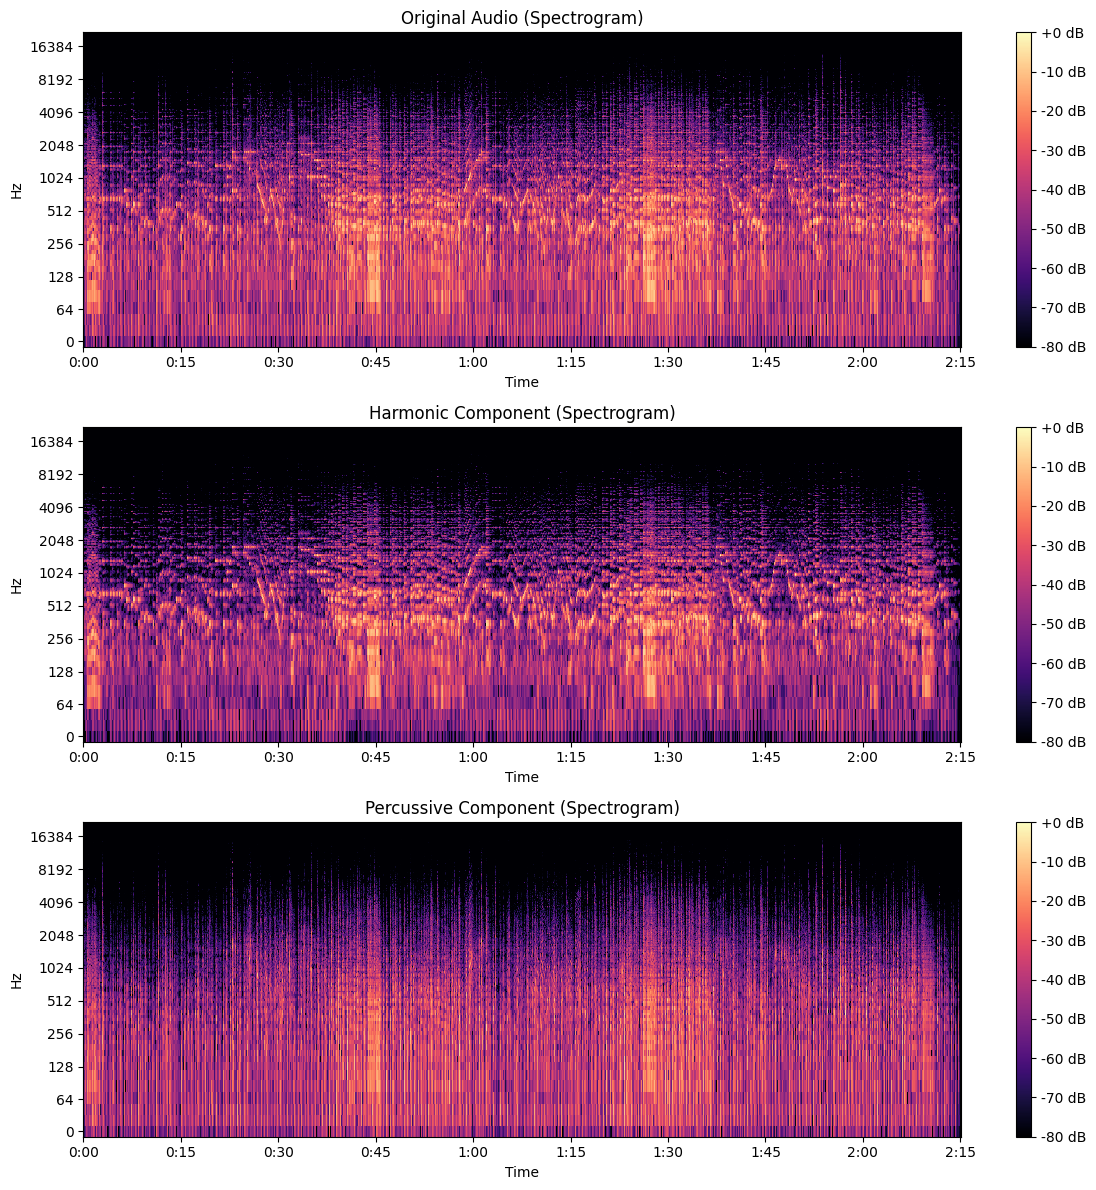

In [ ]:
D_original = librosa.stft(y)
D_harmonic = librosa.stft(harmonic)
D_percussive = librosa.stft(percussive)

D_original_db = librosa.amplitude_to_db(np.abs(D_original), ref=np.max)
D_harmonic_db = librosa.amplitude_to_db(np.abs(D_harmonic), ref=np.max)
D_percussive_db = librosa.amplitude_to_db(np.abs(D_percussive), ref=np.max)

plt.figure(figsize=(12, 12))

plt.subplot(3, 1, 1)
librosa.display.specshow(D_original_db, sr=sr, x_axis="time", y_axis="log")
plt.colorbar(format="%+2.0f dB")
plt.title("Original Audio (Spectrogram)")

plt.subplot(3, 1, 2)
librosa.display.specshow(D_harmonic_db, sr=sr, x_axis="time", y_axis="log")
plt.colorbar(format="%+2.0f dB")
plt.title("Harmonic Component (Spectrogram)")

plt.subplot(3, 1, 3)
librosa.display.specshow(D_percussive_db, sr=sr, x_axis="time", y_axis="log")
plt.colorbar(format="%+2.0f dB")
plt.title("Percussive Component (Spectrogram)")

plt.tight_layout()
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


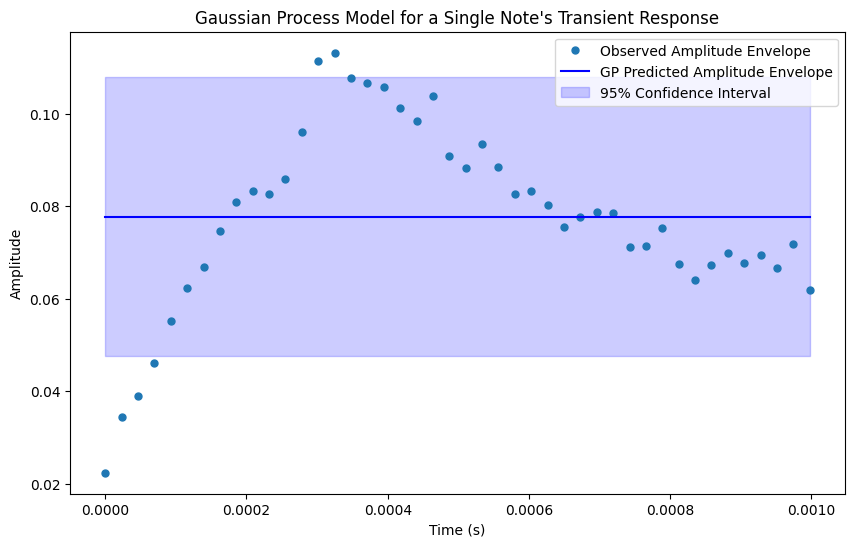

In [ ]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, RationalQuadratic, WhiteKernel

onset_frames = librosa.onset.onset_detect(y=y, sr=sr)
onset_times = librosa.frames_to_time(onset_frames, sr=sr)

onset_sample = librosa.time_to_samples(onset_times[0], sr=sr)
window_size = sr // 2
note_audio = y[onset_sample : onset_sample + window_size]

amplitude_envelope = np.abs(librosa.stft(note_audio)).mean(axis=0)

time = np.linspace(0, len(amplitude_envelope) / sr, len(amplitude_envelope))

kernel = RBF(length_scale=0.1) + RationalQuadratic(length_scale=1.0, alpha=0.1) + WhiteKernel(noise_level=0.01)

gp = GaussianProcessRegressor(kernel=kernel, alpha=1e-2, n_restarts_optimizer=10)
gp.fit(time.reshape(-1, 1), amplitude_envelope)

time_pred = np.linspace(0, len(amplitude_envelope) / sr, 200).reshape(-1, 1)
amplitude_pred, std_dev = gp.predict(time_pred, return_std=True)

plt.figure(figsize=(10, 6))
plt.plot(time, amplitude_envelope, 'o', label="Observed Amplitude Envelope", markersize=5)
plt.plot(time_pred, amplitude_pred, 'b-', label="GP Predicted Amplitude Envelope")
plt.fill_between(
    time_pred.flatten(),
    amplitude_pred - 1.96 * std_dev,
    amplitude_pred + 1.96 * std_dev,
    color='blue',
    alpha=0.2,
    label="95% Confidence Interval"
)
plt.title("Gaussian Process Model for a Single Note's Transient Response")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.legend()
plt.show()


- Deriving the covariance for the tonal part
- Self constructing median filter/looking into tuning the median filtering
- Self constructed filter - running a window in frequency domain and compute the rolling median
- Likelihood functions for tonal and transient parts (basic white noise model for the transients)


**WEEK 4**

In [ ]:
pip install pydub

In [ ]:
from scipy.io import wavfile
from scipy.fft import fft, ifft
from scipy.signal.windows import hamming
from pydub import AudioSegment

In [ ]:
audio = AudioSegment.from_file('/content/drive/MyDrive/middlec.mp3')
sample_rate = audio.frame_rate
audio_data = np.array(audio.get_array_of_samples())

window_size = 13
half_window = window_size // 2
time_window_size = 1024
hop_size = time_window_size // 2

processed_audio = np.zeros(len(audio_data))

time_hamming_window = hamming(time_window_size)
freq_hamming_window = hamming(window_size)

for start in range(0, len(audio_data) - time_window_size, hop_size):
    segment = audio_data[start:start + time_window_size].astype(np.float64)

    segment *= time_hamming_window

    segment_ft = fft(segment)

    filtered_segment_ft = np.copy(segment_ft)
    for i in range(half_window, len(segment_ft) - half_window):
        windowed_section = segment_ft[i - half_window:i + half_window + 1] * freq_hamming_window
        filtered_segment_ft[i] = np.median(np.abs(windowed_section)) # take care of taking median of complex numbers

    filtered_segment = ifft(filtered_segment_ft).real # reconstruct the original restoring the phase

    processed_audio[start:start + time_window_size] += filtered_segment * time_hamming_window

processed_audio = np.int16(processed_audio / np.max(np.abs(processed_audio)) * 32767)

#compare plots of filtered_segment and segment_ft
#use freq resolution to compute window size

In [ ]:
Audio(data=processed_audio, rate=sample_rate)

**DERIVATION OF COVARIANCE FUNCTION**

The power spectrum $ S(\omega) $ is modeled as a mixture of Gaussians:
$
S(\omega) = \sum_{q=1}^{Q} w_q \sum_{m=1}^{M} \frac{E_m}{2} \left[ \phi(\omega; m \omega_q, \sigma_f) + \phi(\omega; -m \omega_q, \sigma_f) \right]
$

where $ \phi(\omega; m \omega_q, \sigma_f) $ represents a Gaussian centered at $ m \omega_q $ with standard deviation $ \sigma_f $, and $ w_q $ and $ E_m $ are weights.


$
\phi(\omega; m \omega_q, \sigma_f) = \exp \left( -\frac{(\omega - m \omega_q)^2}{2 \sigma_f^2} \right)
$

$
\phi(\omega; -m \omega_q, \sigma_f) = \exp \left( -\frac{(\omega + m \omega_q)^2}{2 \sigma_f^2} \right)
$

To find the time-domain covariance function $ k(\tau) $, we take the IFT of $ S(\omega) $:
$
k(\tau) = \mathcal{F}^{-1} \left( S(\omega) \right)
$

Let's calculate the IFT of each Gaussian term individually.

IFT of $ \phi(\omega; m \omega_q, \sigma_f) $:
   The IFT of a Gaussian in the form $ \exp \left( -\frac{(\omega - m \omega_q)^2}{2 \sigma_f^2} \right) $ is another Gaussian in the time domain with an oscillatory component. Specifically:
   $
   \mathcal{F}^{-1} \left( \exp \left( -\frac{(\omega - m \omega_q)^2}{2 \sigma_f^2} \right) \right) = \exp \left( -2 \pi^2 \sigma_f^2 \tau^2 \right) \cos(2 \pi m f_q \tau)
   $
   where $ f_q = \frac{\omega_q}{2 \pi} $

Similarly:
   $
   \mathcal{F}^{-1} \left( \exp \left( -\frac{(\omega + m \omega_q)^2}{2 \sigma_f^2} \right) \right) = \exp \left( -2 \pi^2 \sigma_f^2 \tau^2 \right) \cos(2 \pi m f_q \tau)
   $

Combining Both Terms:
   $
   \mathcal{F}^{-1} \left( \frac{E_m}{2} \left[ \phi(\omega; m \omega_q, \sigma_f) + \phi(\omega; -m \omega_q, \sigma_f) \right] \right) = E_m \exp \left( -2 \pi^2 \sigma_f^2 \tau^2 \right) \cos(2 \pi m f_q \tau)
   $

Summing Over All Components
    $
    k(\tau) = \sum_{q=1}^{Q} w_q \sum_{m=1}^{M} E_m \exp \left( -2 \pi^2 \sigma_f^2 \tau^2 \right) \cos(2 \pi m f_q \tau)
    $

Factoring Out the Exponential Term
  Factor out the common term $ \exp \left( -2 \pi^2 \sigma_f^2 \tau^2 \right) $, giving the final result:
  $
  k(\tau) = \exp \left( -2 \pi^2 \sigma_f^2 \tau^2 \right) \sum_{q=1}^{Q} w_q \sum_{m=1}^{M} E_m \cos(2 \pi m f_q b_{m, f_q} \tau)
  $


**LOG-LIKELIHOOD FUNCTIONS**


$
\log p(\mathbf{y_{tonal}} | \mathbf{x}, \theta) = -\frac{1}{2} \mathbf{y}^T [K + \sigma_n^2 I]^{-1} \mathbf{y} - \frac{1}{2} \log |K + \sigma_n^2 I| - \frac{\ell}{2} \log(2\pi)
$

$
\log p(y_{percussive} | x, \theta) = -\frac{N}{2} \log (2 \pi \sigma^2_p) - \frac{1}{2 \sigma^2_p} \sum_{i=1}^N y_i^2
$

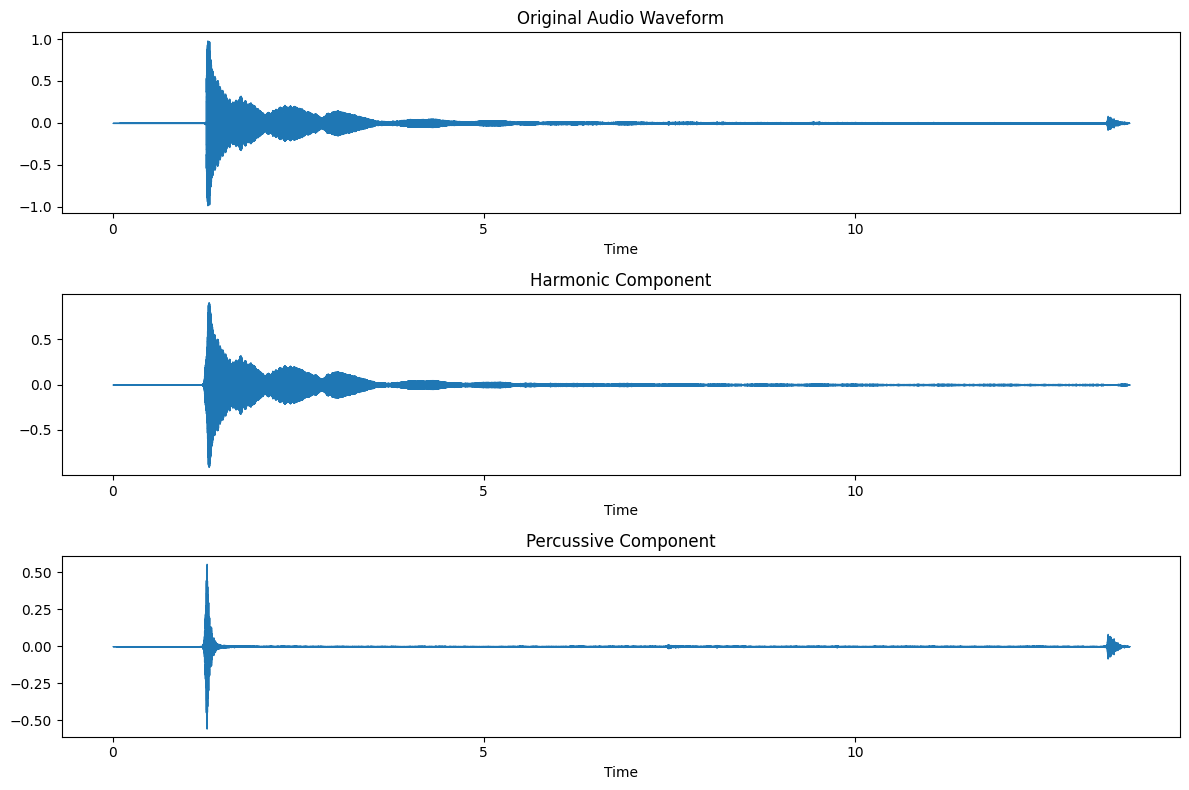

In [ ]:
import scipy.ndimage
import librosa.display

y, sr = librosa.load('/content/drive/MyDrive/middlec.mp3')

harmonic_window_length = 31
percussive_window_length = 31

window_type = "hamming"
overlap_ratio = 0.5
n_fft = 2048
hop_length = int(n_fft * (1 - overlap_ratio))
D = librosa.stft(y, n_fft=n_fft, hop_length=hop_length, window=window_type)

S = np.abs(D)

harmonic_S = scipy.ndimage.median_filter(S, size=(1, harmonic_window_length))
percussive_S = scipy.ndimage.median_filter(S, size=(percussive_window_length, 1))

mask_harmonic = harmonic_S > percussive_S
mask_percussive = percussive_S >= harmonic_S

D_harmonic = D * mask_harmonic
D_percussive = D * mask_percussive

harmonic = librosa.istft(D_harmonic, hop_length=hop_length, window=window_type)
percussive = librosa.istft(D_percussive, hop_length=hop_length, window=window_type)

plt.figure(figsize=(12, 8))
plt.subplot(3, 1, 1)
librosa.display.waveshow(y, sr=sr)
plt.title("Original Audio Waveform")

plt.subplot(3, 1, 2)
librosa.display.waveshow(harmonic, sr=sr)
plt.title("Harmonic Component")

plt.subplot(3, 1, 3)
librosa.display.waveshow(percussive, sr=sr)
plt.title("Percussive Component")

plt.tight_layout()
plt.show()

In [ ]:
Audio(data=harmonic, rate=sr)

In [ ]:
Audio(data=percussive, rate=sr)

**WEEK 5**

In [55]:
audio = AudioSegment.from_file('/content/drive/MyDrive/middlec.mp3')
sample_rate = audio.frame_rate
audio_data = np.array(audio.get_array_of_samples())

window_size = 19
half_window = window_size // 2
time_window_size = 2048
hop_size = time_window_size // 2

processed_audio = np.zeros(len(audio_data))

time_hamming_window = hamming(time_window_size)
freq_hamming_window = hamming(window_size)

for start in range(0, len(audio_data) - time_window_size, hop_size):
    segment = audio_data[start:start + time_window_size].astype(np.float64)

    segment *= time_hamming_window

    segment_ft = fft(segment)

    filtered_segment_ft = np.copy(segment_ft)
    for i in range(half_window, (len(segment_ft)//2)):  # filter till halfway point and then mirror
        windowed_section = segment_ft[i - half_window:i + half_window + 1]

        median_magnitude = np.median(np.abs(windowed_section))
        filtered_segment_ft[i] = median_magnitude * np.exp(1j * np.angle(segment_ft[i]))

    filtered_segment = ifft(filtered_segment_ft).real

    processed_audio[start:start + time_window_size] += filtered_segment * time_hamming_window

    plt.figure(figsize=(14, 6))

    plt.subplot(1, 2, 1)
    plt.plot(np.abs(segment_ft))
    plt.title("Original Frequency Spectrum (Magnitude)")
    plt.xlabel("Frequency Bin")
    plt.ylabel("Magnitude")

    plt.subplot(1, 2, 2)
    plt.plot(np.abs(filtered_segment_ft))
    plt.title("Filtered Frequency Spectrum (Magnitude)")
    plt.xlabel("Frequency Bin")
    plt.ylabel("Magnitude")

    plt.tight_layout()
    plt.show()

processed_audio = np.int16(processed_audio / np.max(np.abs(processed_audio)) * 32767)

#frequency resolution to use the correct window size
#reconstruction of the time domain audio

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
Audio(data=processed_audio, rate=sample_rate)

In [ ]:
processed_audio

In [ ]:
plt.figure(figsize=(12, 8))
plt.subplot(3, 1, 1)
librosa.display.waveshow(processed_audio[600000:700000].astype(np.float64), sr=sr)
plt.title("Transient Audio Waveform")

plt.tight_layout()
plt.show()

**WEEK 6**

In [ ]:
audio = AudioSegment.from_file('/content/drive/MyDrive/middlec.mp3')
sample_rate = audio.frame_rate
audio_data = np.array(audio.get_array_of_samples())
audio_data = audio_data[0:3000000]

# Parameters
window_size = 19
half_window = window_size // 2
time_window_size = 2048
hop_size = time_window_size // 2

# Hamming window
time_hamming_window = hamming(time_window_size)

# Pre-allocate processed audio array
processed_audio = np.zeros(len(audio_data))

# Process in chunks
for start in range(0, len(audio_data) - time_window_size, hop_size):
    # Extract and window the time-domain segment
    segment = audio_data[start:start + time_window_size].astype(np.float64)
    segment *= time_hamming_window

    # Perform FFT
    segment_ft = fft(segment)
    n = len(segment_ft)
    half_len = n // 2 + 1  # Include Nyquist in the positive frequencies

    # Process only the positive frequencies (half spectrum)
    filtered_segment_ft = np.copy(segment_ft)
    for i in range(half_window, half_len - half_window):
        windowed_section = segment_ft[i - half_window:i + half_window + 1]
        median_magnitude = np.median(np.abs(windowed_section))
        filtered_segment_ft[i] = median_magnitude * np.exp(1j * np.angle(segment_ft[i]))

    filtered_segment_ft[half_len:] = np.conj(filtered_segment_ft[1:half_len - 1][::-1])

    filtered_segment = ifft(filtered_segment_ft).real

    processed_audio[start:start + time_window_size] += filtered_segment * time_hamming_window

processed_audio = np.int16(processed_audio / np.max(np.abs(processed_audio)) * 32767)

In [ ]:
Audio(data=processed_audio, rate=sample_rate)

- Progress report
- Runtime fixes
- Presentation slides